![image](../pic/pic1.jpg)
![image](../pic/pic2.jpg)

Длинные названия потому, что за жизненным циклом обектов следить не умею :)

Симулирую **ТОЛЬКО** создание новых связей

In [1]:
Generate_Network_t0 <- function(size = 40, sparsity = 0.7) {
	network <- matrix(0, nrow=size, ncol=size)
  
	for (i in 1:size) {
		for (j in 1:size) {
			if (runif(1) > sparsity) {
				network[i, j] <- 1
			}
		}
	}
  
	return(network)
}


Network_function_1 <- function(i, Network) { # outdegree (density)
	net <- sum(Network[i, ])
	return(net)
}


Network_function_3 <- function(i, Network) { # transitive triads (transTrip)
	net <- 0
	for (j in 1:length(Network[i, ])) {
		for(h in 1:length(Network[i, ])){
			if(i!=j & j != h){
				net <- net + (Network[i,j] * Network[i,h] * Network[h,j]) 
			}
		}
	}
	return(net)
}

Generate_Possible_Ministep_Matrix_vector <- function(i, Network) {
	Networks <- list()
  
	for (j in 1:length(Network[i, ])) {
		if (i != j) {
			TMP_Net <- Network
			TMP_Net[i, j] <- 1
			Networks[[j]] <- TMP_Net    
		}
	}
	return(Networks)
}

Ministep <- function(Network, i, j) {
	Network[i, j] <- 1
	return(Network)
}


Distribution_actors <- function(i, Network, beta) {
	Util <- numeric( length(Network[i, ]) )
	total_util <- 0
  
	for (h in 1:length(Network[i, ])) {
		if (i != h) {
			total_util <- total_util + exp(Utility(Network, beta, i, h))
		}
	}
  
	Util_j <- numeric(length(Network[i, ]))
  
	for (j in 1:length(Network[i, ])) {
		if (j != i) {
			Util_j[j] <- exp(Utility(Network, beta, i, j))
            # print(Util_j[j])
            # print(total_util)
			Util[j] <- Util_j[j] / total_util
		}
	}
	Util[which(is.na(Util))] <- 0
	return(Util)
}

Utility <- function(Network, beta, i, j) {
	util <- 0
	util <- util + (beta[1] * Network_function_1(i, Network)) + (beta[2] * Network_function_3(i, Network))
	return(util)
}

Simulator <- function(Network0, t = 0, LambdaV, total_Lambda, T, beta) {
	Network <- Network0 
	while (t < T) {
		deltaT <- rexp(1, rate=total_Lambda)
		i <- sample(1:length(Network0[1, ]), size=1, prob=(LambdaV / total_Lambda))
      
		prob_vector <- 0
		prob_vector <- Distribution_actors(i, Network, beta)
        # print(sum(prob_vector))
		j <- sample(1:length(Network0[i,]), size=1, prob=prob_vector)
		Network[i, j] <- 1
		t <- t + deltaT

	}
	return(Network)
}


In [2]:
size <- 30
Network0 <- Generate_Network_t0(size = size)
LambdaV <- runif(n = size, min = 0.1, max = 1) 
total_Lambda <- sum(LambdaV)
total_Lambda
# beta <- c(runif(n = 1, min = -10, max = 10), runif(n = 1, min = -10, max = 10)) 
beta <- c(1.3,1.6)
T <- 5

[1] 13.74398

In [3]:
Network1 <- Simulator(Network0, t = 0, LambdaV, total_Lambda, T, beta)

In [4]:
Network2 <- Simulator(Network1, t = 0, LambdaV, total_Lambda, T, beta)

In [5]:
sum(Network0)
sum(Network1)
sum(Network2)

[1] 273

[1] 321

[1] 368

---
# Проверка в RSiena

In [6]:
library(RSiena)

In [7]:



Networks <- array(c(Network0, Network1, Network2), dim = c(size, size, 3))

Networks <- sienaDependent(Networks, nodeSet="Actors")

Networks
     

Type         oneMode             
Observations 3                   
Nodeset      Actors (30 elements)


In [8]:
mydata <- sienaDataCreate(Networks)
myeff <- getEffects(mydata)
mydata

For dependent variable Networks, in some periods,

there are only increases, or only decreases.

This will be respected in the simulations. 

If this is not desired, use allowOnly=FALSE when creating the dependent variable.



Dependent variables:  Networks 
Number of observations: 3 

Nodeset                  Actors 
Number of nodes              30 

Dependent variable Networks     
Type               oneMode      
Observations       3            
Nodeset            Actors       
Densities          0.3 0.36 0.41

"uponly":  Networks:    all periods

Сиена видит коэффиценты разреженности. Они идентичны заданным.

Так же в предупреждении указано, что сеть только увеличивалась или уменьшалась, что корректно отвечает заданным условиям. 

In [9]:
# myeff <- includeEffects(myeff, outPop, type = "creation", include =TRUE)
# myeff <- includeEffects(myeff, outRate, type = "rate", include =TRUE)
# myeff <- includeEffects(myeff, outRateLog, type = "rate", include = TRUE)

# myeff <- includeEffects(myeff, transTrip, type = "creation", include = TRUE)
myeff <- includeEffects(myeff, transTrip, include = TRUE)

  effectName          include fix   test  initialValue parm
1 transitive triplets TRUE    FALSE FALSE          0   0   


In [10]:
summary(myeff)

,name,effectName,functionName,shortName,interaction1,interaction2,type,basicRate,include,randomEffects,⋯,effect3,interactionType,local,setting,effectFn,statisticFn,netType,groupName,group,effectNumber
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,⋯,<int>,<chr>,<lgl>,<chr>,<list>,<list>,<chr>,<chr>,<dbl>,<int>
Networks.rate.1,Networks,constant Networks rate (period 1),Amount of network change in period 1,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,1
Networks.rate.2,Networks,constant Networks rate (period 2),Amount of network change in period 2,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,2
Networks.obj.eval.1,Networks,reciprocity,Number of reciprocated ties,recip,,,eval,FALSE,TRUE,FALSE,⋯,0,dyadic,TRUE,,NULL,NULL,oneMode,Group1,1,12
Networks.obj.eval.2,Networks,transitive triplets,Number of transitive triplets,transTrip,,,eval,FALSE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,18


In [11]:
myalgorithm <- sienaAlgorithmCreate(projname = 'Тест симулятора сети')
ans <- siena07( myalgorithm, data = mydata, effects = myeff, clusterType="FORK", useCluster=TRUE, nbrNodes=12)

If you use this algorithm object, siena07 will create/use an output file Тест симулятора сети.txt .


In [12]:
ans

Estimates, standard errors and convergence t-ratios

                                   Estimate   Standard   Convergence 
                                                Error      t-ratio   

Rate parameters: 
  0.1      Rate parameter period 1 1.6555   ( 0.2455   )             
  0.2      Rate parameter period 2 1.6247   ( 0.2363   )             

Other parameters: 
  1.  eval reciprocity             0.2287   ( 0.2361   )    0.0214   
  2.  eval transitive triplets     0.0418   ( 0.0666   )   -0.0847   

Overall maximum convergence ratio:    0.0895 


Total of 1774 iteration steps.


Необходимо помнить, что оцениваем $ exp(\text{парамтер}) $ (Для созданных мной параметров)

---
Скриптом `../data/main.r` запустил 40 повторов. Графики сходимости (сходимости ли ?).
В скрипт немного отличается от Ноубтбука. Правки вроде случайных начальных парметров

beta - мои параметры. 
- beta1 - density
- beta2 - transTrip

teta - оцененые параметры

rate - оцененая скорость
- rate1 - 1 период
- rate2 - 2 период

totalLambda - суммарная интенсивность всех акторов (задана)

In [1]:
beta <- read.table("../data/beta.txt", sep = " ")
rate <- read.table("../data/rate.txt", sep = " ")
teta <- read.table("../data/teta.txt", sep = " ") # Почему то записывается только первый столбец, 
                                                  # но если запустить в jupyter 
                                                  # То выводятся оба
total_lambda <- read.table("../data/totalLambda.txt", sep = " ")

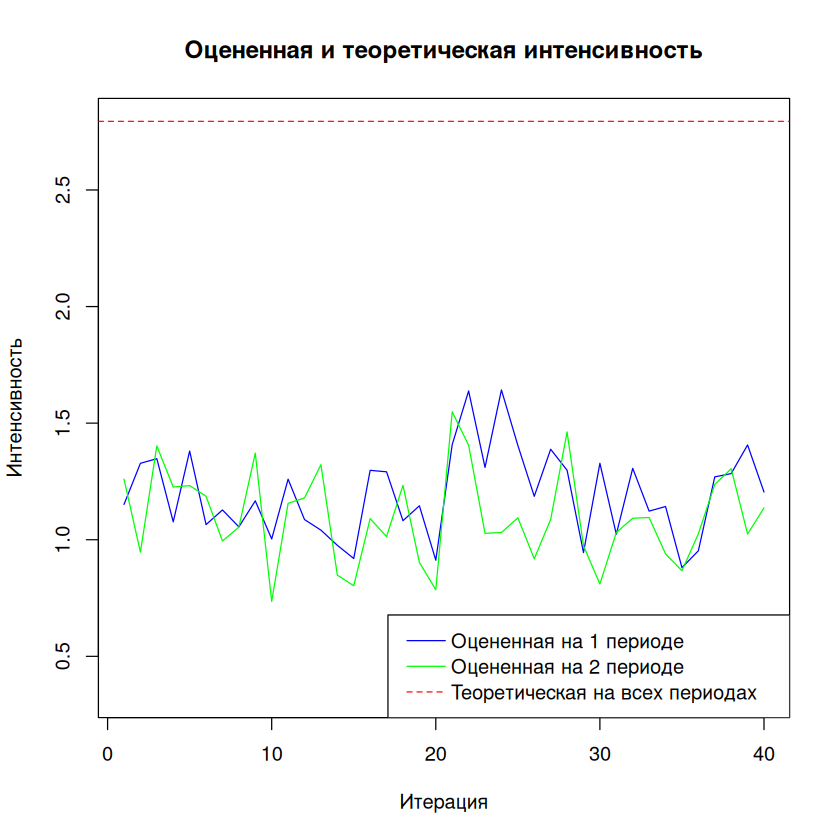

In [26]:
log_total_lambda <- log(total_lambda$V1[1])

min_y <- min(min(rate$V1), min(rate$V2), log_total_lambda) - .4
max_y <- max(max(rate$V1), max(rate$V2), log_total_lambda)

plot(rate$V1, type = "l", col = "blue", ylim = c(min_y, max_y), 
     xlab = "Итерация", ylab = "Интенсивность", main = "Оцененная и теоретическая интенсивность")

lines(rate$V2, type = "l", col = "green")
abline(h = log_total_lambda, col = "red", lty = 2)

legend("bottomright", legend = c("Оцененная на 1 периоде", "Оцененная на 2 периоде", "Теоретическая на всех периодах"),
       col = c("blue", "green", "red"), lty = c(1, 1, 2), x.intersp = .3)




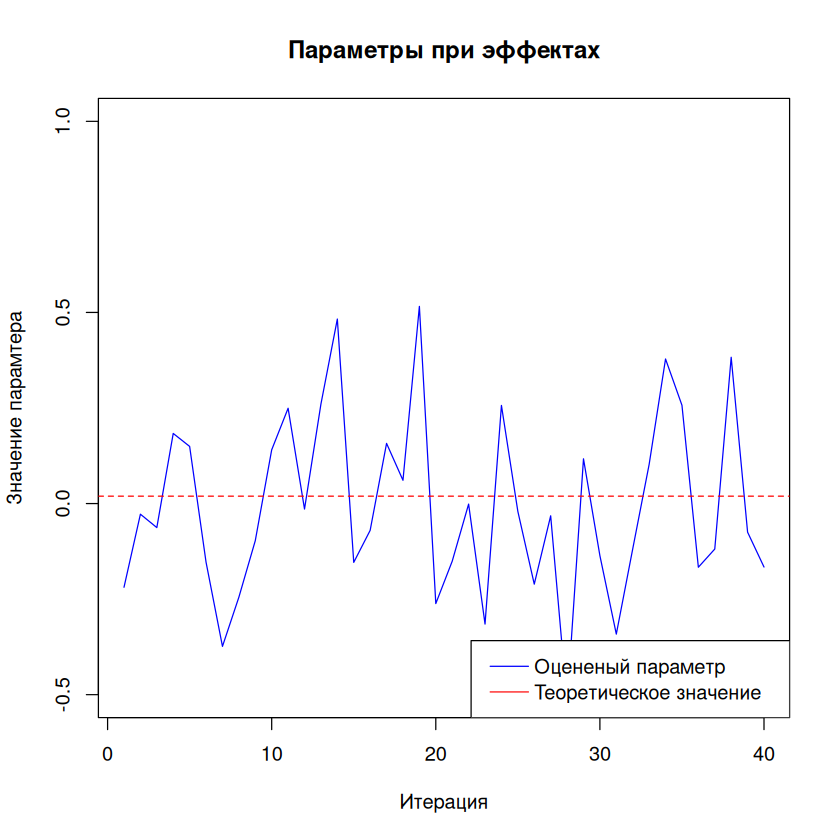

In [28]:
plot(teta$V1, type="l", col="blue", ylim=c(-.5, 1), main = "Параметры при эффектах", xlab = "Итерация", ylab = "Значение парамтера",)
abline(h = log(abs(beta$V1[1])), col = "red", lty = 2)
# abline(h = log(abs(beta$V2[2])), col = "orange", lty = 2)
# lines(teta$V2, col = "green", lty = 2)

legend("bottomright", legend = c("Оцененый параметр", "Теоретическое значение"),
       col = c("blue", "red"), lty = c(1, 1), x.intersp = .3)